In [1]:
DATASET_DIR = "/kaggle/input/dicommammography"
!rm -rf ./* # clear working dir
VINDR_SELECTED_SUBSET_CSV = DATASET_DIR+'/vindr-mammo_selected_images.csv'
VINDR_BIRADS_1_2_CSV = DATASET_DIR+'/vindr-mammo_birads-1_2.csv'
VINDR_ALL_CSV = 'https://drive.usercontent.google.com/u/1/uc?id=12dZ1KqdOs79jB17uFAfvrb-J4EatpQPr&export=download'
VINDR_MULTI_VIEW_CSV = DATASET_DIR+'/vindr_cc_mlo_data.csv'
CBIS_DDSM_ALL_CSV = DATASET_DIR+'/cbis_ddsm_all.csv'
CBIS_DDSM_MULTI_VIEW_CSV = DATASET_DIR+'/cbis_ddsm_dual_view_all.csv'


VINDR_ZIP_FINDINGS_ONLY = DATASET_DIR+'/vindr-mammo_findings_only'
VINDR_ZIP_SELECTED_SUBSET = DATASET_DIR+'/VinDr-Mammo_Balanced_Subset'
VINDR_ZIP_BIRADS_1_2 = DATASET_DIR+'/VinDr-Mammo_BIRADS_1&2_Subset'
CBIS_ZIP_CALC_TRAIN = DATASET_DIR+'/CBIS-DDSM_Calc_Training'
CBIS_ZIP_CALC_TEST = DATASET_DIR+'/CBIS-DDSM_Calc_Test'
CBIS_ZIP_MASS_TRAIN = DATASET_DIR+'/CBIS-DDSM_Mass_Training'
CBIS_ZIP_MASS_TEST = DATASET_DIR+'/CBIS-DDSM_Mass_Test'

cbis_zip_list = [CBIS_ZIP_MASS_TRAIN, CBIS_ZIP_CALC_TRAIN, CBIS_ZIP_MASS_TEST, CBIS_ZIP_CALC_TEST]
label_index = {"BI-RADS 0": 0.0,"BI-RADS 1":1.0,"BI-RADS 2":2.0,"BI-RADS 3":3.0,"BI-RADS 4":4.0,"BI-RADS 5":5.0,}
index_label = {val:key for key,val in label_index.items()}

import os
import random
import pandas as pd
import numpy as np
# import tensorflow as tf

def seed_everything(seed):
    print("seed everything using", seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     tf.random.set_seed(seed)

seed_everything(int(1e4*np.e))

columns = ['pair_id', 'image_path_CC', 'zip_file_CC', 'BI_RADS_CC',
                      'image_path_MLO',  'zip_file_MLO', 'BI_RADS_MLO',
           'CC_MLO_Same_BIRADS']
vindr_multi_view = pd.read_csv(VINDR_MULTI_VIEW_CSV)
vindr_multi_view['pair_id'] = vindr_multi_view.apply(lambda row: f"{row['study_id']}_{row['laterality']}" , axis=1)
vindr_multi_view = vindr_multi_view.loc[:,columns]
cbis_multi_view = pd.read_csv(CBIS_DDSM_MULTI_VIEW_CSV)\
                  .rename(columns={
                      'subset_zip_CC':'zip_file_CC',
                      'subset_zip_MLO':'zip_file_MLO',
                      'assessment_CC':'BI_RADS_CC',
                      'assessment_MLO':'BI_RADS_MLO'
                      })
cbis_multi_view = cbis_multi_view.loc[:,columns]

# all_multi_view_df = cbis_multi_view
all_multi_view_df = pd.concat([vindr_multi_view, cbis_multi_view]).reset_index(drop=True)

def normalize_birads(row):
    if row['BI_RADS_CC'] in label_index and row['BI_RADS_MLO'] in label_index:
        row['BI_RADS_CC'] = label_index[row['BI_RADS_CC']]
        row['BI_RADS_MLO'] = label_index[row['BI_RADS_MLO']]
        return row
    else:
        row['BI_RADS_CC'] = float(row['BI_RADS_CC'])
        row['BI_RADS_MLO'] = float(row['BI_RADS_MLO'])
        return row
    
def kaggle_zipfile_path(row):
    for view in ['CC', 'MLO']:
        orig_zip_file = row[f'zip_file_{view}']
        if not isinstance(orig_zip_file, str):
            continue
        kaggle_filename = orig_zip_file.split('/')[-1].replace('.zip','_zip').replace('&','')
        kaggle_zip_file = f"{DATASET_DIR}/{kaggle_filename}"
        row[f'zip_file_{view}'] = kaggle_zip_file
    return row

all_multi_view_df = all_multi_view_df.apply(normalize_birads, axis=1)
all_multi_view_df = all_multi_view_df.apply(kaggle_zipfile_path, axis=1)
all_multi_view_df = all_multi_view_df.dropna().reset_index(drop=True)
all_multi_view_df['BI_RADS_MAX'] = all_multi_view_df.apply(lambda row: max(row['BI_RADS_CC'], row['BI_RADS_MLO']), axis=1)
all_multi_view_df

seed everything using 27182


,pair_id,image_path_CC,zip_file_CC,BI_RADS_CC,image_path_MLO,zip_file_MLO,BI_RADS_MLO,CC_MLO_Same_BIRADS,BI_RADS_MAX
0,0025a5dc99fd5c742026f0b2b030d3e9_L,vindr-mammo/451562831387e2822923204cf8f0873e.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,vindr-mammo/2ddfad7286c2b016931ceccd1e2c7bbc.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,True,1.0
1,0025a5dc99fd5c742026f0b2b030d3e9_R,vindr-mammo/fcf12c2803ba8dc564bf1287c0c97d9a.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,vindr-mammo/47c8858666bcce92bcbd57974b5ce522.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,True,1.0
2,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_L,vindr-mammo/3704f91985dcbc69f6ac2803523d1ecb.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/7fc1f1bb8bb1a7efaf7104e49c4d8b86.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0
3,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_R,vindr-mammo/c4ce68631bf70949570ded31a3c69e60.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/16e58fc1d65fa7587247e6224ee96527.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0
4,0034765af074f93ed33d5e8399355caf_L,vindr-mammo/68f09c18925a66ef2840d4a62f237b31.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/b664cf1e7c968896144a3a2005cd3eb4.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0
...,...,...,...,...,...,...,...,...,...
2688,P_02460_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0
2689,P_02508_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,True,4.0
2690,P_02518_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0
2691,P_02559_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,True,3.0


In [2]:
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom

## Dataset Splitting

In [3]:
# list index yang gambar mamografinya ada kotak putih gede / otsu roi crop malah ngecrop bagian itu -.-
drop_indexes = [106, 107, 1245, 1420] # index lainya yang udah fix : 1730, 1844, 1909, 1947, 2068, 2086, 2149, 2316, 2347, 2367, 2401, 2408, 2418, 2419, 2453, 2478, 2590, 2653]
ds = all_multi_view_df.drop(drop_indexes).sample(frac=1).reset_index(drop=True)
birads_counts = ds.BI_RADS_MAX.value_counts()
print(len(ds))
print('\n'.join([f"{label} : {birads_counts.get(i)}" for label, i in label_index.items()]))

2689
BI-RADS 0 : None
BI-RADS 1 : 464
BI-RADS 2 : 415
BI-RADS 3 : 500
BI-RADS 4 : 971
BI-RADS 5 : 339


In [4]:
def get_kfold_df(k, kfold_ds=ds.copy(), balanced=True):
    kfold_ds[f"k{k}_split"] = "fold-sisa"
    def train_val_split(_df, k):
        split = 1 / k
        split = round(len(_df)*split) # splitting to k-fold / (100/k)% data each fold
        start_index = 0
        indxs = list(_df.index)
        for i in range(k):
            indx = indxs[start_index:(i+1)*split]
            _df.loc[indx, f"k{k}_split"] = f'fold-{i}'
            start_index+=split
        return _df
    if balanced:
        get_n_sample = lambda _ : birads_counts.min()
        lowest_count_birads = birads_counts.argmin() + 1.0
        low_birads = kfold_ds.loc[ds.BI_RADS_MAX == lowest_count_birads]
        kfold_ds.loc[kfold_ds.BI_RADS_MAX == lowest_count_birads] = train_val_split(low_birads, k)
    else:
        lowest_count_birads = -1
        get_n_sample = lambda df: len(df)
    
    for key in index_label:
        if key == lowest_count_birads or key == 0.0:
            continue
        biradn = kfold_ds.loc[kfold_ds.BI_RADS_MAX == key]
        biradn = biradn.sample(get_n_sample(biradn))
        biradn = train_val_split(biradn, k)
        kfold_ds.iloc[biradn.index,:] = biradn
    return kfold_ds

def print_kfold_birads_counts(k, balanced=True):
    kfold_ds = get_kfold_df(k, balanced=balanced)
    print(kfold_ds[f"k{k}_split"].value_counts())
    for i in range(k):
        fold_birads_counts = kfold_ds[kfold_ds[f"k{k}_split"] == f"fold-{i}"].BI_RADS_MAX.value_counts()
        print(f"fold-{i} birads".center(30, "-"))
        print('\n'.join([f"{label} : {fold_birads_counts.get(i)}" for label, i in label_index.items()]))
    fold_birads_counts = kfold_ds[kfold_ds[f"k{k}_split"] == "fold-sisa"].BI_RADS_MAX.value_counts()
    print(f"fold-sisa birads".center(30, "-"))
    print('\n'.join([f"{label} : {fold_birads_counts.get(i)}" for label, i in label_index.items()]))

In [5]:
print_kfold_birads_counts(k=3)

k3_split
fold-sisa    994
fold-1       565
fold-0       565
fold-2       565
Name: count, dtype: int64
--------fold-0 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
--------fold-1 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
--------fold-2 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
-------fold-sisa birads-------
BI-RADS 0 : None
BI-RADS 1 : 125
BI-RADS 2 : 76
BI-RADS 3 : 161
BI-RADS 4 : 632
BI-RADS 5 : None


In [6]:
#  balanced-fold unbalance dataset
print_kfold_birads_counts(k=3, balanced=False)

k3_split
fold-1       897
fold-0       897
fold-2       894
fold-sisa      1
Name: count, dtype: int64
--------fold-0 birads---------
BI-RADS 0 : None
BI-RADS 1 : 155
BI-RADS 2 : 138
BI-RADS 3 : 167
BI-RADS 4 : 324
BI-RADS 5 : 113
--------fold-1 birads---------
BI-RADS 0 : None
BI-RADS 1 : 155
BI-RADS 2 : 138
BI-RADS 3 : 167
BI-RADS 4 : 324
BI-RADS 5 : 113
--------fold-2 birads---------
BI-RADS 0 : None
BI-RADS 1 : 154
BI-RADS 2 : 138
BI-RADS 3 : 166
BI-RADS 4 : 323
BI-RADS 5 : 113
-------fold-sisa birads-------
BI-RADS 0 : None
BI-RADS 1 : None
BI-RADS 2 : 1
BI-RADS 3 : None
BI-RADS 4 : None
BI-RADS 5 : None


In [7]:
k_range = 3, 6
for balancing in ["balanced", "unbalanced"]:
    balanced = True if balancing=="balanced" else False
    kfold_ds = ds.copy()
    collumns_to_save = ["pair_id","BI_RADS_MAX"]
    for k in range(*k_range):
        kfold_ds = get_kfold_df(k, kfold_ds, balanced)
        collumns_to_save.append(f"k{k}_split")
    kfold_ds = kfold_ds.loc[:, collumns_to_save].rename(columns={"BI_RADS_MAX":"label"})
    print(len(kfold_ds))
    kfold_ds.to_csv(f"{balancing}_k-fold_splits.csv",index=False)
kfold_ds.head()

2689
2689


,pair_id,label,k3_split,k4_split,k5_split
0,5a2b5febd11b2fdd2c7f4fd1d0f92104_L,4.0,fold-1,fold-2,fold-4
1,P_02393_LEFT,3.0,fold-1,fold-0,fold-0
2,P_01679_RIGHT,4.0,fold-2,fold-2,fold-2
3,4141898a609bbcdf7fa4e9b49188514e_R,4.0,fold-0,fold-1,fold-0
4,P_01739_LEFT,3.0,fold-1,fold-0,fold-2


## processing DICOM

In [8]:
#@title function to load dicom
# core function from :
# https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way/notebook

import cv2
import pydicom
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
from io import BytesIO


def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

def extract_roi_otsu(img, gkernel=(5, 5)):
    """WARNING: this function modify input image inplace."""
    ori_h, ori_w = img.shape[:2]
    # clip percentile: implant, white lines
    upper = np.percentile(img, 80)
    img[img > upper] = np.min(img)
    # Gaussian filtering to reduce noise (optional)
    if gkernel is not None:
        img = cv2.GaussianBlur(img, gkernel, 0)
    _, img_bin = cv2.threshold(img, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # dilation to improve contours connectivity
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3), (-1, -1))
    img_bin = cv2.dilate(img_bin, element)
    cnts, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:  # gagal mendeteksi roi , gambar digunakan apa adanya
        return [0, 0, ori_w, ori_h], -1
    areas = np.array([cv2.contourArea(cnt) for cnt in cnts])
    select_idx = np.argmax(areas)
    cnt = cnts[select_idx]
    area_pct = areas[select_idx] / (img.shape[0] * img.shape[1])
    x0, y0, w, h = cv2.boundingRect(cnt)
    # min-max for safety only
    # x0, y0, x1, y1
    x1 = min(max(int(x0 + w), 0), ori_w)
    y1 = min(max(int(y0 + h), 0), ori_h)
    x0 = min(max(int(x0), 0), ori_w)
    y0 = min(max(int(y0), 0), ori_h)
    return [x0, y0, x1, y1], area_pct

def otsu_roi_crop(data, area_pct_tresh=0.02):
    (x0, y0, x1, y1), area_pct = extract_roi_otsu(data.copy(), gkernel=(3, 3))
    if area_pct >= area_pct_tresh:
        data = data[y0:y1,x0:x1]
    return data, area_pct

def pad_to_scale_ratio(img, laterality, scale):
    height, width = img.shape[:2]
    target_ratio = scale[0] / scale[1]

    if width / height > target_ratio:  # Image is wider than 9:16
        new_width = width
        new_height = int(width / target_ratio)
        top_bottom_padding = (new_height - height) // 2
        left_right_padding = 0
    else:  # Image is taller than 9:16
        new_width = int(height * target_ratio)
        new_height = height
        top_bottom_padding = 0
        if laterality == "R":
            left_right_padding = (new_width - width)
        else:
            left_right_padding = 0

    # Create a blank image with the target dimensions
    padded_img = np.zeros((new_height, new_width), dtype=np.uint8)

    # Copy the original image onto the padded image with the calculated offsets
    padded_img[top_bottom_padding:top_bottom_padding + height, 
               left_right_padding:left_right_padding + width] = img

    return padded_img

def get_laterality(data):
    sum_L = np.sum(data[:, :20])
    sum_R = np.sum(data[:, -20:])
    if sum_L == sum_R:
        laterality = "<?>"
    else:
        laterality = 'L' if sum_L > sum_R else 'R'
    return laterality

def read_dicom(path,
               voi_lut:bool=True,
               fix_monochrome:bool=True,
               pad_scale:tuple=None,
               roi_crop:str=None,
               resize:tuple|list=(288, 512),
               area_pct_tresh:float=0.04,
               ):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    # otsu roi cropping
    if roi_crop == 'otsu':
        data, area_pct = otsu_roi_crop(data, area_pct_tresh)
    # padding
    if pad_scale is not None:
        data = pad_to_scale_ratio(data, get_laterality(data), pad_scale)
    # resize
    if resize is not None:
        data = cv2.resize(data, resize, interpolation=cv2.INTER_LINEAR)

    return data, area_pct

class D:
    voi_lut = True
    fix_monochrome = True
    roi_crop = "otsu"
    resize = (288, 512)
    padding = (9,16)
    area_pct_tresh = 0.02
    
def load_dicom_from_zip(image_path, zipfile_path, return_laterality=False):
    kwargs = {
      "voi_lut" : D.voi_lut,
      "fix_monochrome" : D.fix_monochrome,
      "roi_crop" : D.roi_crop,
      "resize" : D.resize,
      "pad_scale": D.padding,
      "area_pct_tresh":D.area_pct_tresh
    }
    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        with zip_ref.open(image_path) as f:
            image_bytes = BytesIO(f.read())
    dicom_data, area_pct = read_dicom(image_bytes, **kwargs)
    del image_bytes
    if return_laterality:
        return dicom_data, get_laterality(dicom_data), area_pct
    else:
        return dicom_data

In [9]:
# image_path_cc, zipfile_path_cc = all_multi_view_df.loc[0, ["image_path_CC","zip_file_CC"]]
# load_dicom_from_zip(image_path_cc, zipfile_path_cc)

> catatan : terdapat inkonsistensi pada dataset CBIS-DDSM , laterality pada idnya tertulis "LEFT" tapi gambarnya "R" dan sebaliknya

kesimpulan : dapat diabaikan

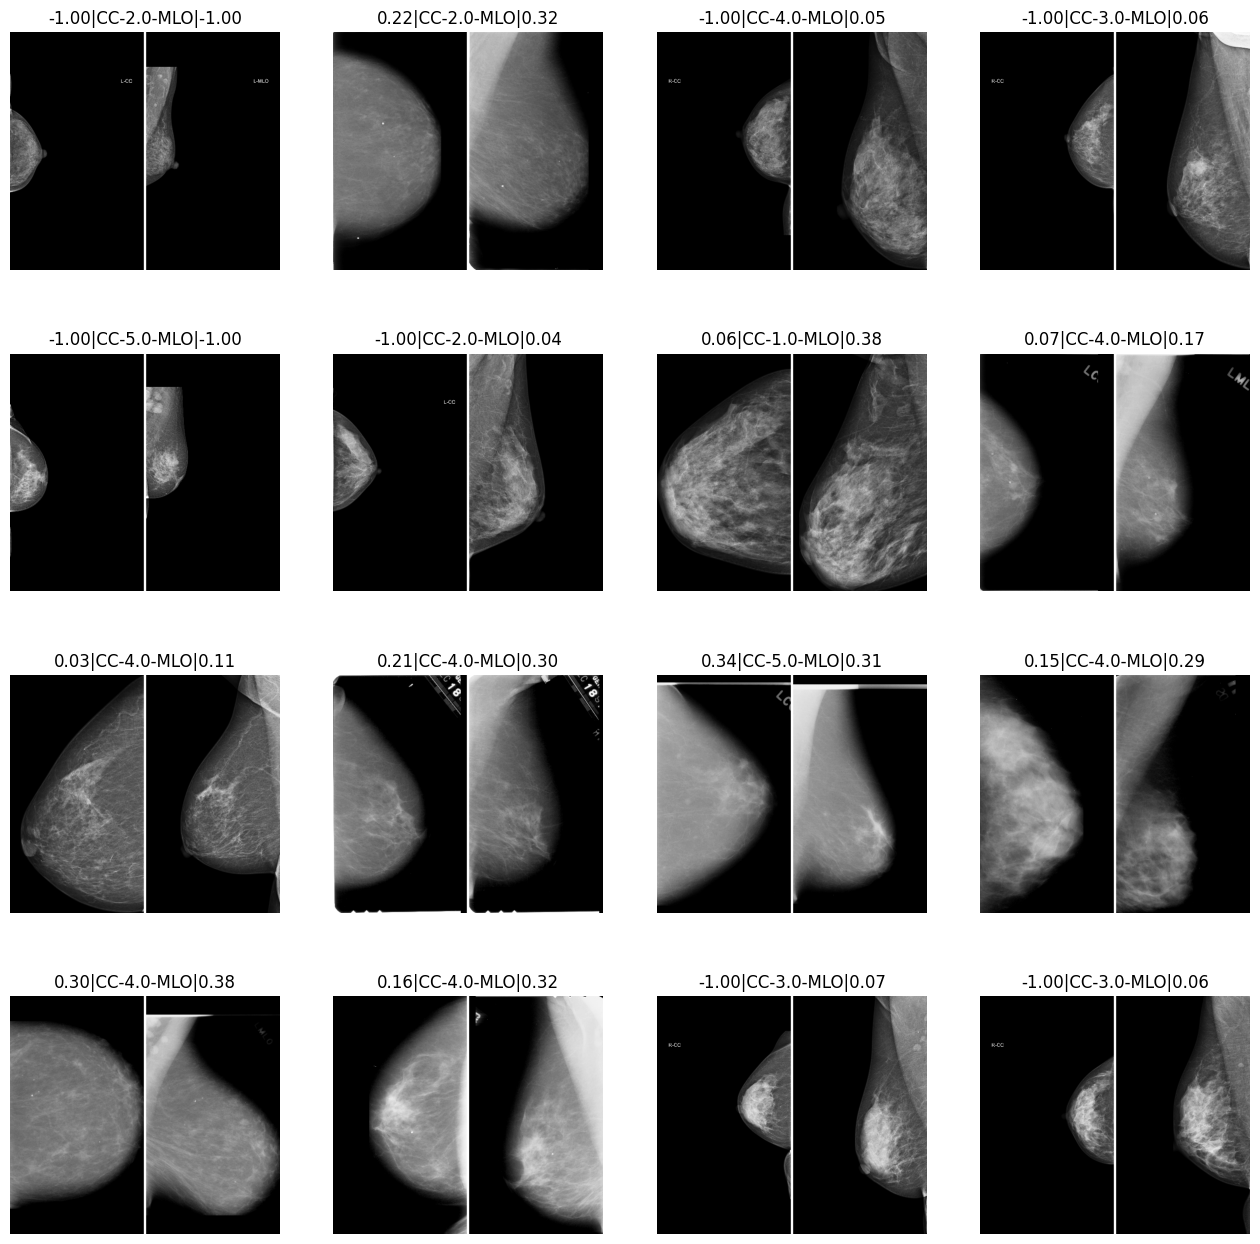

In [10]:
ncol = 4
nrow = 4
bar_color = [255]
# ds = all_multi_view_df.copy().loc[index,:].reset_index(drop=True)
ds = all_multi_view_df.copy().sample(frac=1).reset_index(drop=True)

bar_thickness = 5
bar = np.array([bar_color * bar_thickness]*D.resize[1])
random_index = np.random.randint(0,(len(ds)-ncol*nrow)) if len(ds) > (ncol*nrow) else 0

plt.figure(figsize=(4*ncol, 4*nrow))
for i in range(nrow*ncol):
    _id0, image_path_cc, zipfile_path_cc = ds.loc[random_index+i, ["BI_RADS_MAX","image_path_CC","zip_file_CC"]]
    img_cc, lat0, area_pct0 = load_dicom_from_zip(image_path_cc, zipfile_path_cc, return_laterality=True)
    _id1, image_path_mlo, zipfile_path_mlo = ds.loc[random_index+i, ["BI_RADS_MAX","image_path_MLO","zip_file_MLO"]]
    img_mlo, lat1, area_pct1 = load_dicom_from_zip(image_path_mlo, zipfile_path_mlo, return_laterality=True)
    img = np.hstack((img_cc,bar,img_mlo))
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{area_pct0:.2f}|CC-{_id0}-MLO|{area_pct1:.2f}")
    plt.axis("off")
plt.show()

# Convert DICOM to PNG images

In [11]:
import os
import multiprocessing as mp
from tqdm.auto import tqdm

base_dir = ""
cardinality = 999999999999 

def load_and_save(row):
    global base_dir
    index, row = row
    lats = {}
    for view in ["CC", "MLO"]:
        filename = os.path.join(base_dir, f"{row['pair_id']}-{view}.png")
        if os.path.exists(filename):
            lats[view] = ""
            continue
        zipfile_path = row[f'zip_file_{view}']
        image_path = row[f'image_path_{view}']
        img_data, lat , area_percent = load_dicom_from_zip(image_path, zipfile_path, return_laterality=True)
        cv2.imwrite(filename, img_data)
        lats[view] = lat
    if not lats['CC'] == lats['MLO']:
        return index+1
    return 0

def convert_dicoms_to_pngs(folder_name, kfold_ds):
    global base_dir
    base_dir = f'/kaggle/working/{folder_name}'
    print("saving PNG images to", base_dir)
    os.makedirs(base_dir, exist_ok=True)
    # start process
    with mp.Pool(mp.cpu_count()) as p:
        iterrows = list(kfold_ds.iterrows())[:cardinality]
        image_generator = tqdm(
            p.imap_unordered(load_and_save, iterrows),
            total=len(iterrows),
            desc="converting images"
        )
        r = list(image_generator)
        sumr = sum(r)
        print(sum(r))
        if sumr > 0:
            for idx in r:
                if idx > 0:
                    print(idx-1)

print("creating images dataset".center(50, "."))
convert_dicoms_to_pngs("images", ds)

.............creating images dataset..............
saving PNG images to /kaggle/working/images


converting images:   0%|          | 0/2693 [00:00<?, ?it/s]

22174
176
346
474
769
808
861
941
1153
1308
1378
1416
1653
1750
1931
2131
2410
2652


In [12]:
import os
import zipfile

base_dir = 'example_dicom'
!rm -rf {base_dir}
os.makedirs(base_dir, exist_ok=True)

def save_dicom(image_path, zipfile_path, save_filename):
    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        with zip_ref.open(image_path) as f:
            image_bytes = f.read()
    with open(save_filename, "wb") as f:
        f.write(image_bytes)
    
n_data_to_save = 1
df_list = []
for key in index_label:
    if key == 0.0:
        continue
    biradn = ds.loc[ds.BI_RADS_MAX == key].sample(n_data_to_save)
    df_list.append(biradn)

sample_df = pd.concat(df_list, ignore_index=True)
for _, row in sample_df.iterrows():
    label = int(row['BI_RADS_MAX'])
    for view in ["CC", "MLO"]:
        save_filename = os.path.join(base_dir, f"birads_{label}_example_{view}.dicom")
        if os.path.exists(save_filename):
            continue
        zipfile_path = row[f'zip_file_{view}']
        image_path = row[f'image_path_{view}']
        save_dicom(image_path, zipfile_path, save_filename)
        
!tar -zcvf example_dicom_tar_gz {base_dir} && rm -rf {base_dir}

example_dicom/
example_dicom/birads_2_example_CC.dicom
example_dicom/birads_2_example_MLO.dicom
example_dicom/birads_4_example_MLO.dicom
example_dicom/birads_5_example_MLO.dicom
example_dicom/birads_3_example_CC.dicom
example_dicom/birads_1_example_CC.dicom
example_dicom/birads_3_example_MLO.dicom
example_dicom/birads_4_example_CC.dicom
example_dicom/birads_5_example_CC.dicom
example_dicom/birads_1_example_MLO.dicom


In [13]:
# import cv2
# import numpy as np
# import tensorflow as tf

# print(tf.__version__)

# im = cv2.imread("/kaggle/working/images/a235482f737d9a3baa8313c8f4db16d6_L-MLO.png")
# im = cv2.resize(im, (1024, 1024))
# # im = cv2.flip(im, 1)

# # interpreter = tf.lite.Interpreter("/kaggle/input/mammo-roi-detector/tflite/yolov5/1/best-fp16.tflite")
# # interpreter.allocate_tensors()
# # inputs = interpreter.get_input_details()[0]
# # output = interpreter.get_output_details()[0]
# # interpreter.set_tensor(inputs["index"], np.expand_dims(im, 0).astype("float32"))
# # interpreter.invoke()
# # o = interpreter.get_tensor(output["index"])
# # index, total_boxes = tf.image.non_max_suppression_padded(
# #     o[...,:4],
# #     o[...,4],
# #     1,
# #     iou_threshold=0.5,
# #     score_threshold=0.5,
# #     pad_to_max_output_size=True,
# # )
# # print(o[0, index[0]])

# import cv2

# def get_bbox_absolute_pixel(bbox, image_shape):
#     if not len(image_shape) == 3:
#         raise NotImplementedError("this function expect image shape with len == 3")
#     h, w, _ = image_shape
#     bbox = np.array(bbox)
#     if not len(bbox.shape) == 1:
#         raise NotImplementedError("this function expect bbox shape with len == 1")
#     bbox[[0,2]]*=w
#     bbox[[1,3]]*=h
#     bbox = bbox.astype(int)
#     return bbox

# def xywh2xyxy(bbox):
#     x0, y0, w, h = bbox
#     x1 = x0 + w
#     y1 = y0 + h
#     return x0, y0, x1, y1

# # bbox = get_bbox_absolute_pixel(o[0, index[0], :4][0], im.shape)
# # bbox = xywh2xyxy(bbox)
# bbox = np.array(crop_coords(np.mean(im, axis=-1)))
# bbox = xywh2xyxy(bbox)
# print(bbox)
# x_min, y_min, x_max, y_max = bbox
# img = cv2.rectangle(im.astype("uint8"), (x_min, y_min), (x_max, y_max), (255, 0, 0), 5)
# # img = im[y_min:y_max,x_min:x_max]

# sum_L = np.sum(img[:, :20])
# sum_R = np.sum(img[:, -20:])
# laterality = 'L' if sum_L > sum_R else 'R'
# print(laterality)
# plt.imshow(img)

In [14]:
# def get_label(file_path):
#     path_parts = tf.strings.split(file_path, os.path.sep)
#     filename_parts = tf.strings.split(path_parts[-1], "_")
#     label = tf.strings.to_number(filename_parts[-3],out_type=tf.dtypes.int32)

#     return tf.one_hot(label-1,5)

# def decode_img(img):
#     img = tf.io.decode_png(img, channels=3)
#     # Resize the image to the desired size
#     return tf.image.resize(img, (512,288))

# def process_image(file_path):
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(file_path)
#     img = decode_img(img)
#     return img

# splits = ['train', 'valid', 'sisa']
# view_map = {"Examined":"CC", "Aux":"MLO"}
# dict_dataset = { split:[{v:None for v in view_map},[]] for split in splits}
# images_dir = '/kaggle/working/images'

# #https://www.tensorflow.org/tutorials/load_data/images?hl=en#using_tfdata_for_finer_control
# for split in splits:
#     for view in view_map:
#         dict_dataset[split][0][view] = tf.data.Dataset.list_files(f"{images_dir}/*_{view_map[view]}_{split}.png",shuffle=False)
# for split in splits:
#     for view in view_map:
#         ds = dict_dataset[split][0][view]
#         print(f'{view}-{split} cardinality :',ds.cardinality().numpy())
#         print('examples :')
#         for f in ds.take(2):
#             print(f.numpy())
#         print()
        
# for split in splits:
#     dict_dataset[split][1] = dict_dataset[split][0][view].map(get_label, num_parallel_calls=tf.data.AUTOTUNE)
#     for view in view_map:
#         dict_dataset[split][0][view] = dict_dataset[split][0][view].map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

# for image in dict_dataset['train'][0]['Examined'].take(5):
#     print("Image shape: ", image.numpy().shape)
# for label in  dict_dataset['train'][1].take(5):
#     print("Label: ", label.numpy())
    
# print("\nunique labels :\n",np.unique(list(dict_dataset['valid'][1].as_numpy_iterator()), axis=0))

# train_ds = tf.data.Dataset.zip(tuple(dict_dataset['train']))
# validation_ds = tf.data.Dataset.zip(tuple(dict_dataset['valid']))
# test_ds = tf.data.Dataset.zip(tuple(dict_dataset['sisa']))


# del dict_dataset
# train_ds

In [15]:
# def _bytes_feature(value):
#     """Returns a bytes_list from a string / byte."""
#     if isinstance(value, type(tf.constant(0))):  # if value is tensor
#         value = value.numpy()  # get value of tensor
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def serialize_example(image_dict, label):
#     feature = {
#       'Examined': _bytes_feature(image_dict['Examined'].numpy().tobytes()),
#       'Aux': _bytes_feature(image_dict['Aux'].numpy().tobytes()),
#       'label': _bytes_feature(label.numpy().tobytes())  # Assuming one-hot encoded
#     }
#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

# # Function to write TFRecord file
# def write_tfrecord(dataset, output_file):
#     with tf.io.TFRecordWriter(output_file) as writer:
#         for image_dict, label in dataset:
#             example = serialize_example(image_dict, label)
#             writer.write(example)

# # Create separate TFRecord files for training and validation
# write_tfrecord(train_ds, 'train.tfrecord')
# write_tfrecord(validation_ds, 'valid.tfrecord')
# write_tfrecord(test_ds, 'sisa.tfrecord')